# FIN 666-Advanced Quant Methods and Machine Learning in Finance
# Homework 7: VAR Model of US Economy
## Peter Chika Ozo-ogueji

### Summary of Homework 7: Vector Autoregression (VAR) Analysis of U.S. Monetary Policy
### This assignment explores the impact of monetary policy on key macroeconomic indicators, specifically inflation and unemployment rates in the United States. The primary objective is to build and analyze a Vector Autoregression (VAR) model that captures the interactions between the unemployment rate, inflation rate, and the federal funds rate. The dataset for this analysis will be sourced from the Federal Reserve Economic Data (FRED), covering the period from 1970 to 2019 to avoid distortions caused by the COVID-19 pandemic.
### The first step involves checking the stationarity of the variables and determining whether transformations such as differencing are necessary before applying the VAR model. Once stationarity is confirmed, the optimal order of the VAR model will be selected using various information criteria methods, such as the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC). The VAR model will then be estimated, and the relationships between the three economic indicators will be interpreted to assess how changes in one variable affect the others over time.
### Following model estimation, residual analysis will be conducted to evaluate whether the assumptions of the model are met, ensuring that there is no serial correlation or patterns left unexplained. The dataset will then be split into training and testing subsets, with the last eight quarters reserved for out-of-sample testing. The trained VAR model will be used to forecast the test period, and the accuracy of these forecasts will be assessed by comparing predicted values with actual data. Performance will be evaluated using Mean Absolute Percentage Error (MAPE) and Root Mean Squared Error (RMSE) to measure forecast reliability.
### Additionally, Granger causality tests will be conducted to determine whether any of the variables can predict changes in the others, revealing potential causal relationships within the economic system. Finally, based on the findings, a policy recommendation will be formulated, advising the Federal Reserve on possible actions to address rising inflation and unemployment.
### This assignment integrates time series modeling, macroeconomic analysis, and forecasting techniques to develop a data-driven understanding of U.S. monetary policy. The insights derived from this study will contribute to a better understanding of how interest rate adjustments influence the economy and inform future policy decisions.



## Part (a): Checking for stationarity

First few rows of the dataset:
            unemployment  inflation  fed_funds
DATE                                          
1971-01-01      5.933333   4.813366   3.856667
1971-04-01      5.900000   4.313811   4.566667
1971-07-01      6.033333   4.270262   5.476667
1971-10-01      5.933333   3.536264   4.750000
1972-01-01      5.766667   3.505848   3.546667


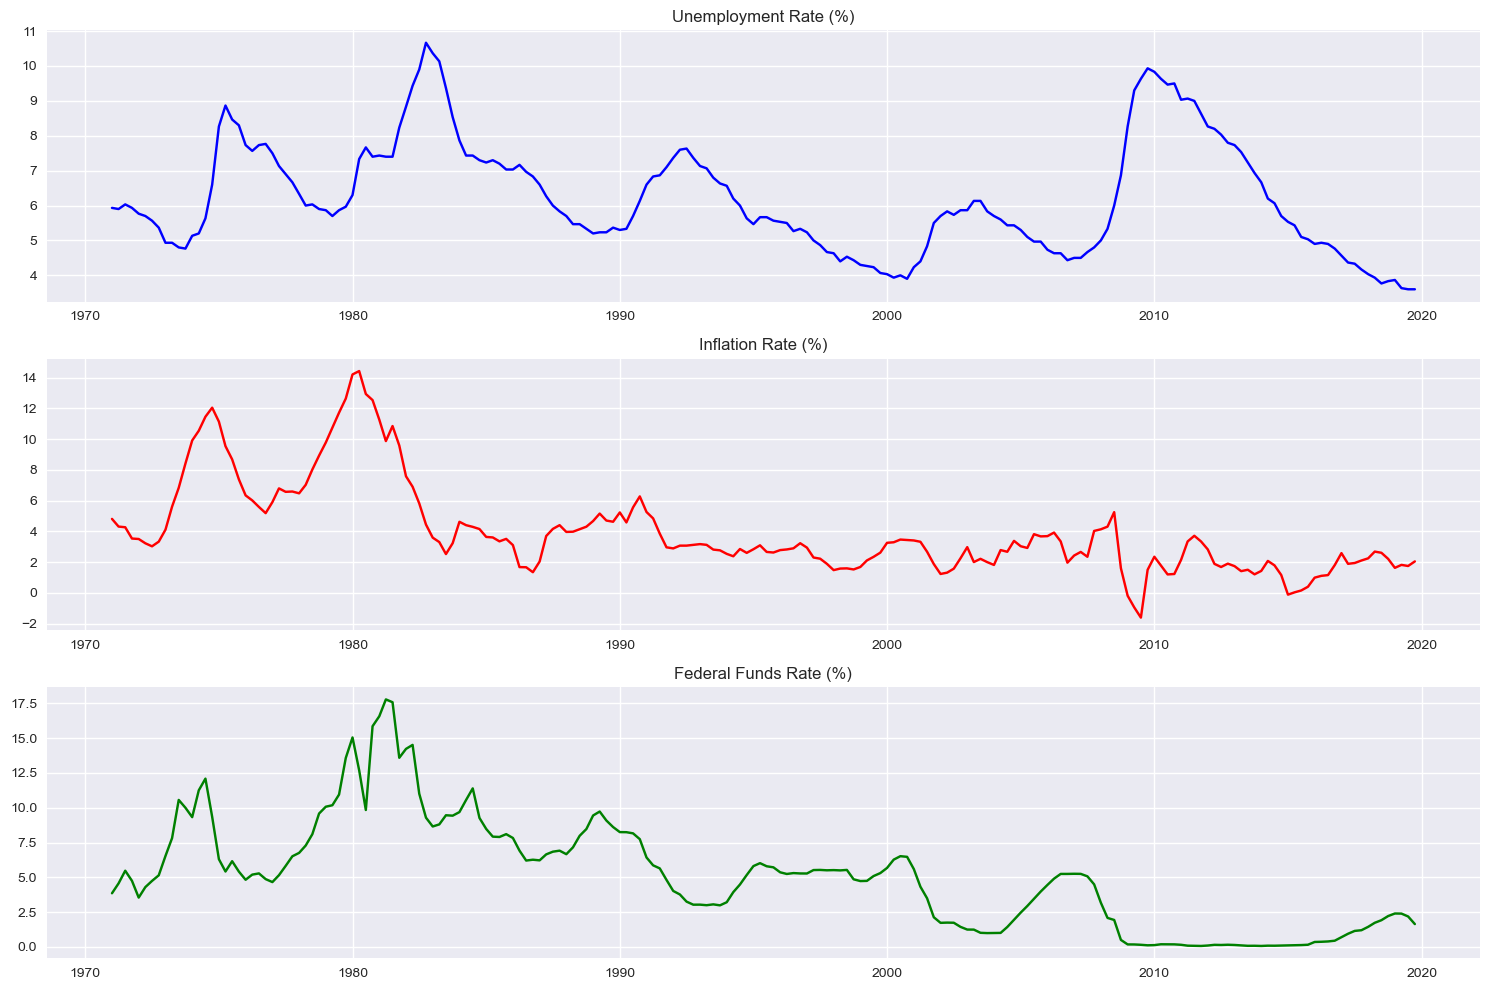


(a) Checking stationarity of the variables using Augmented Dickey-Fuller test:

Unemployment Rate:
ADF Statistic: -2.8857
p-value: 0.0470
Critical Values: {'1%': -3.466005071659723, '5%': -2.8772078537639385, '10%': -2.5751221620996647}
Result: Variable is stationary

Inflation Rate:
ADF Statistic: -1.6939
p-value: 0.4343
Critical Values: {'1%': -3.466598080268425, '5%': -2.8774669520682674, '10%': -2.5752604356654425}
Result: Variable is non-stationary

Federal Funds Rate:
ADF Statistic: -1.6217
p-value: 0.4718
Critical Values: {'1%': -3.465620397124192, '5%': -2.8770397560752436, '10%': -2.5750324547306476}
Result: Variable is non-stationary

Transforming Inflation Rate by taking first difference.

Transforming Federal Funds Rate by taking first difference.

Checking stationarity of transformed variables:

First difference of inflation:
ADF Statistic: -5.8750
p-value: 0.0000
Critical Values: {'1%': -3.4674201432469816, '5%': -2.877826051844538, '10%': -2.575452082332012}
Result: Var

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# For time series analysis
import statsmodels.graphics.tsaplots as sgt  # for ACF and PACF plots
import statsmodels.tsa.stattools as sts      # for Augmented Dickey-Fuller test of stationarity
from scipy.stats.distributions import chi2

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['figure.dpi'] = 100

# Data Retrieval
from pandas_datareader import data

# Define date range: 1970 to 2019
start = datetime(1970, 1, 1)
end = datetime(2019, 12, 31)

# Download data from FRED
# 1. Unemployment Rate (UNRATE)
# 2. Inflation Rate (CPIAUCSL - Consumer Price Index for All Urban Consumers)
# 3. Federal Funds Rate (FEDFUNDS)

# Unemployment Rate
unemployment = data.DataReader('UNRATE', data_source='fred', start=start, end=end)

# Consumer Price Index for calculating inflation
cpi = data.DataReader('CPIAUCSL', data_source='fred', start=start, end=end)

# Federal Funds Rate
fed_funds = data.DataReader('FEDFUNDS', data_source='fred', start=start, end=end)

# Data Preparation
# Convert monthly CPI to inflation rate (year-over-year percentage change)
cpi['inflation'] = cpi['CPIAUCSL'].pct_change(12) * 100

# Convert all data to quarterly frequency to match GDP data common in economic analysis
unemployment_q = unemployment.resample('QS').mean()
inflation_q = cpi.resample('QS').mean()
fed_funds_q = fed_funds.resample('QS').mean()

# Combine all series into one DataFrame
df = pd.DataFrame({
    'unemployment': unemployment_q['UNRATE'],
    'inflation': inflation_q['inflation'],
    'fed_funds': fed_funds_q['FEDFUNDS']
})

# Drop rows with NaN values (due to the lag in calculating inflation)
df = df.dropna()

# Display the first few rows of the combined dataset
print("First few rows of the dataset:")
print(df.head())

# Plot the data
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(df.index, df['unemployment'], 'b-')
plt.title('Unemployment Rate (%)')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(df.index, df['inflation'], 'r-')
plt.title('Inflation Rate (%)')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(df.index, df['fed_funds'], 'g-')
plt.title('Federal Funds Rate (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Check for stationarity of the variables
print("\n(a) Checking stationarity of the variables using Augmented Dickey-Fuller test:")

def check_stationarity(series, name):
    result = sts.adfuller(series.dropna())
    print(f"\n{name}:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Critical Values: {result[4]}")
    if result[1] <= 0.05:
        print("Result: Variable is stationary")
        return True
    else:
        print("Result: Variable is non-stationary")
        return False

# Check stationarity for each variable
stationary_unemployment = check_stationarity(df['unemployment'], 'Unemployment Rate')
stationary_inflation = check_stationarity(df['inflation'], 'Inflation Rate')
stationary_fed_funds = check_stationarity(df['fed_funds'], 'Federal Funds Rate')

# Transform non-stationary variables by taking first difference
df_transformed = df.copy()
transformed_vars = []

if not stationary_unemployment:
    df_transformed['d_unemployment'] = df['unemployment'].diff()
    transformed_vars.append('d_unemployment')
    print("\nTransforming Unemployment Rate by taking first difference.")
else:
    transformed_vars.append('unemployment')

if not stationary_inflation:
    df_transformed['d_inflation'] = df['inflation'].diff()
    transformed_vars.append('d_inflation')
    print("\nTransforming Inflation Rate by taking first difference.")
else:
    transformed_vars.append('inflation')

if not stationary_fed_funds:
    df_transformed['d_fed_funds'] = df['fed_funds'].diff()
    transformed_vars.append('d_fed_funds')
    print("\nTransforming Federal Funds Rate by taking first difference.")
else:
    transformed_vars.append('fed_funds')

# Drop rows with NaN values due to differencing
df_transformed = df_transformed.dropna()

# Check stationarity of transformed variables
print("\nChecking stationarity of transformed variables:")
for var in transformed_vars:
    if var.startswith('d_'):
        check_stationarity(df_transformed[var], f'First difference of {var[2:]}')

# Prepare data for VAR model
var_data = df_transformed[transformed_vars]

## Part (b): Selecting optimal lag order

In [5]:
# Import VAR model
from statsmodels.tsa.api import VAR

# b) Select the order of the VAR model using information criteria
print("\n(b) Selecting the order of the VAR model using information criteria:")

model = VAR(var_data)
order_selection = model.select_order(maxlags=12)
print(order_selection.summary())

# Determine the optimal lag order based on AIC
optimal_lag = order_selection.aic

print(f"\nOptimal lag order based on AIC: {optimal_lag}")


(b) Selecting the order of the VAR model using information criteria:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       0.1243      0.1769       1.132      0.1456
1       -3.394      -3.183     0.03358      -3.309
2       -4.017     -3.649*     0.01801      -3.868
3       -4.038      -3.512     0.01763      -3.825
4       -4.147      -3.463     0.01583      -3.870
5       -4.312      -3.470     0.01342     -3.971*
6       -4.262      -3.263     0.01412      -3.857
7       -4.314      -3.156     0.01343      -3.845
8      -4.467*      -3.152    0.01154*      -3.934
9       -4.451      -2.978     0.01176      -3.854
10      -4.428      -2.797     0.01206      -3.767
11      -4.383      -2.594     0.01265      -3.658
12      -4.401      -2.455     0.01247      -3.612
--------------------------------------------------

Optimal lag order based on AIC: 8


## Part (c): Estimating the VAR model

In [7]:
# c) Estimate the VAR model
print(f"\n(c) Estimating the VAR({optimal_lag}) model:")

var_model = model.fit(maxlags=optimal_lag)
print(var_model.summary())



(c) Estimating the VAR(8) model:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 20, Mar, 2025
Time:                     14:47:11
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -3.11669
Nobs:                     187.000    HQIC:                  -3.88749
Log likelihood:          -308.447    FPE:                  0.0121824
AIC:                     -4.41259    Det(Omega_mle):      0.00836084
--------------------------------------------------------------------
Results for equation unemployment
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.206460         0.089086            2.318           0.020
L1.unemployment         1.567160         0.083312           18.811           0.000
L1.d_inflat

## # Interpret the relations between variables:

### Based on the Vector Autoregressive model results, this analysis examines the intricate relationships between unemployment, inflation, and federal funds rate in the U.S. economy:
### The unemployment equation reveals pronounced persistence characteristics, evidenced by a statistically significant positive first-order autoregressive coefficient (1.567) followed by a significant negative second-order coefficient (-0.464). These statistics demonstrate unemployment's inherent momentum and eventual mean-reverting tendencies. Monetary policy, as measured by changes in the federal funds rate, exhibits delayed but significant impacts on unemployment at the sixth and eighth lags (coefficients of 0.065 and 0.058 respectively). This empirical finding corroborates macroeconomic theory regarding monetary policy transmission delays, indicating that contractionary policy manifests in labor markets approximately 1.5-2 years after implementation. Notably, inflation differentials demonstrate no statistically significant direct effect on unemployment across any of the specified lags.
### Regarding inflation dynamics, unemployment emerges as a significant determinant with a complex temporal pattern: a negative first-order coefficient (-0.702), followed by a substantial positive second-order coefficient (1.395), and another significant negative effect at the fourth lag (-0.816). This oscillating pattern suggests a sophisticated cyclical relationship between labor market conditions and price level changes. Federal funds rate changes exhibit consistent positive effects on inflation across early lags (0.120, 0.122, and 0.174 at lags 1-3 respectively), potentially capturing the endogenous monetary policy response function rather than exogenous policy effects. The inflation equation also displays a complex autoregressive structure with alternating significant coefficients across multiple lags (0.372, 0.242, -0.668, 0.308, and -0.374 at lags 1, 3, 4, 5, and 8 respectively).
### The federal funds rate equation indicates substantial responsiveness to unemployment fluctuations, characterized by alternating coefficients: negative at lags 1 (-1.043) and 6 (-1.207), and positive at lags 2 (1.326) and 4 (1.521). This pattern suggests nuanced monetary policy reactions to labor market developments over different time horizons. The federal funds rate also demonstrates complex autoregressive behavior, with significant negative coefficients at lags 2 (-0.180), 6 (-0.216), and 7 (-0.260), counterbalanced by a positive coefficient at lag 5 (0.210). Contrary to conventional theoretical expectations, inflation differentials exhibit limited direct influence on monetary policy adjustments within this empirical framework.
### The residual correlation matrix provides supplementary insights: the moderate negative correlation (-0.388) between unemployment and federal funds rate innovations suggests these variables respond to common unobserved factors. Similarly, the positive correlation (0.271) between inflation and federal funds rate innovations indicates potential contemporaneous interactions or mutual responses to exogenous shocks.
### These empirical findings yield several critical policy implications: monetary policy impacts on unemployment materialize with substantial lags (approximately 1.5-2 years); the unemployment-inflation nexus exhibits complex bidirectional dynamics rather than simple contemporaneous relationships; and Federal Reserve policy appears more responsive to labor market conditions than to inflation fluctuations. These results enhance our understanding of macroeconomic policy transmission mechanisms and underscore the importance of forward-looking policy formulation that accounts for significant implementation lags and complex variable interactions.



## Part (d): Evaluating residuals:


(d) Evaluating the residuals:


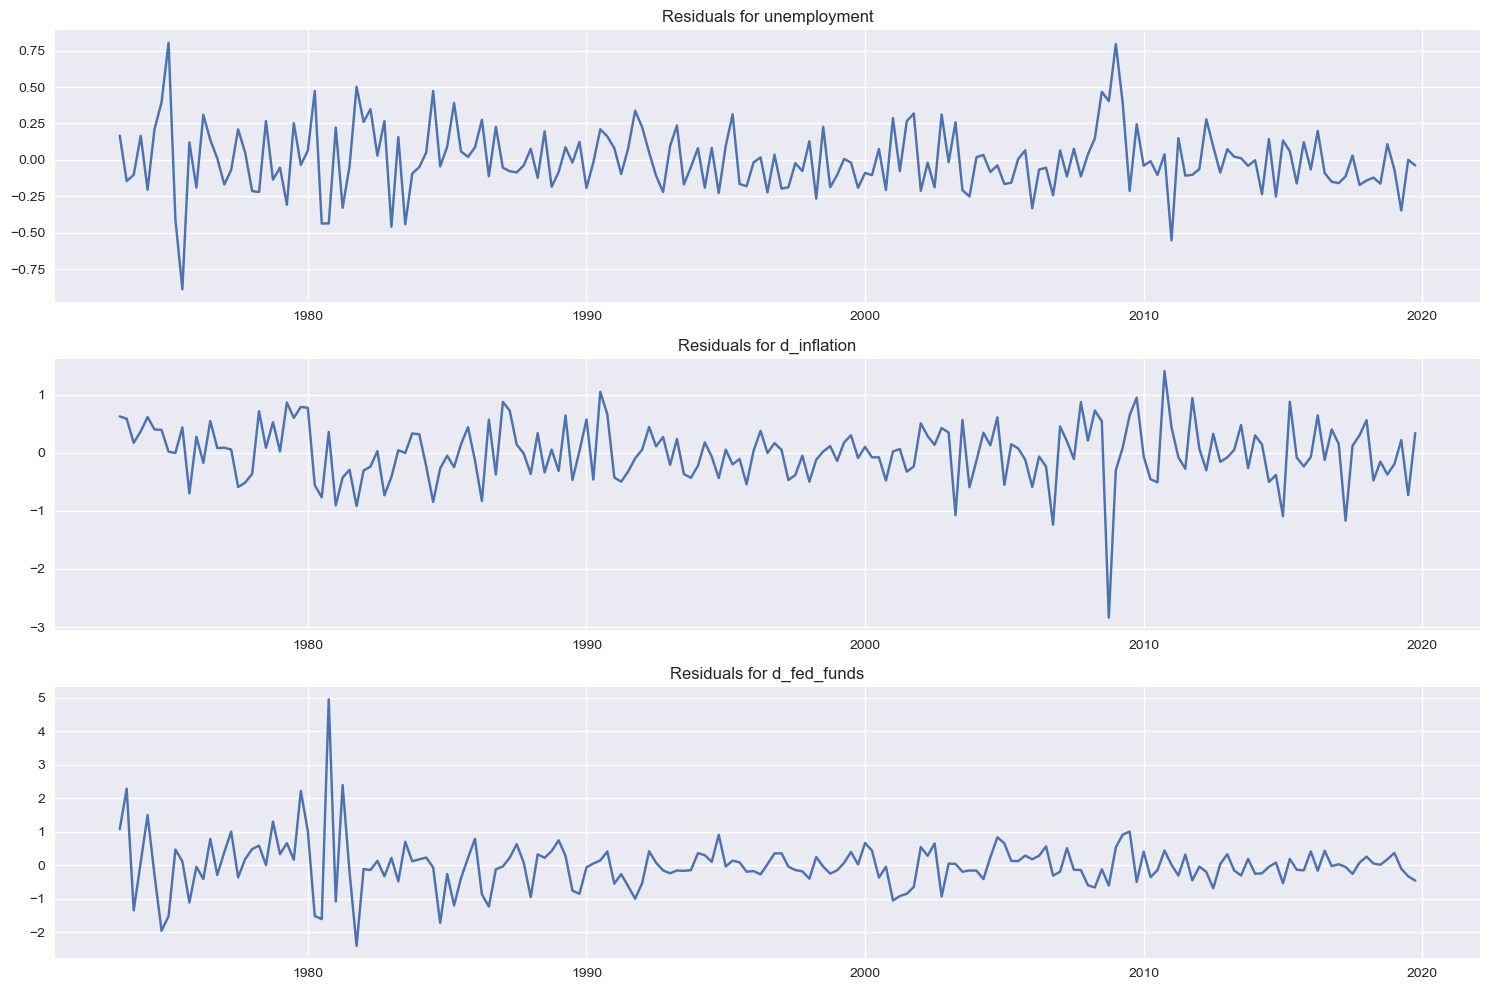

<Figure size 1200x600 with 0 Axes>

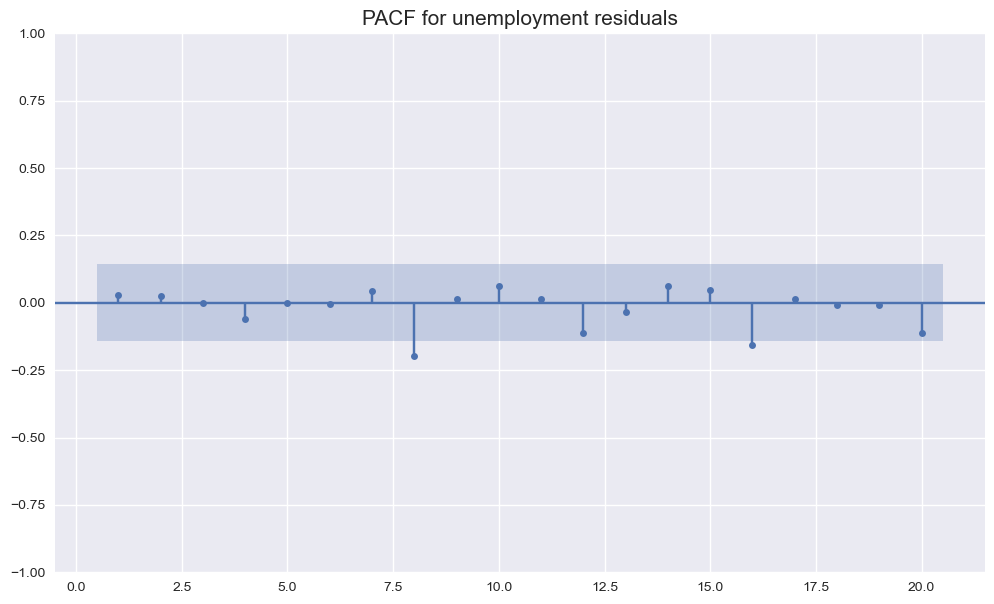

<Figure size 1200x600 with 0 Axes>

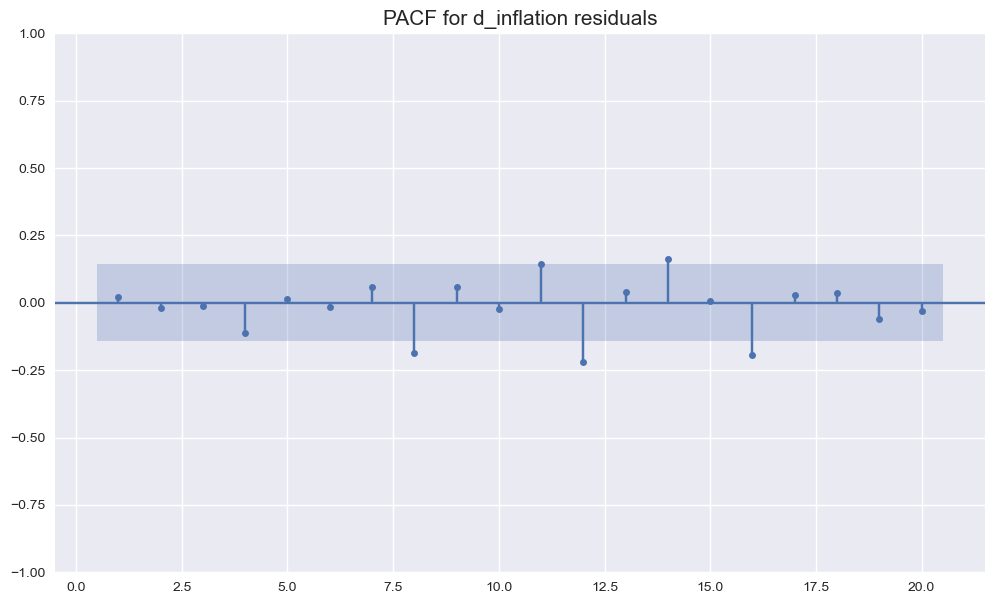

<Figure size 1200x600 with 0 Axes>

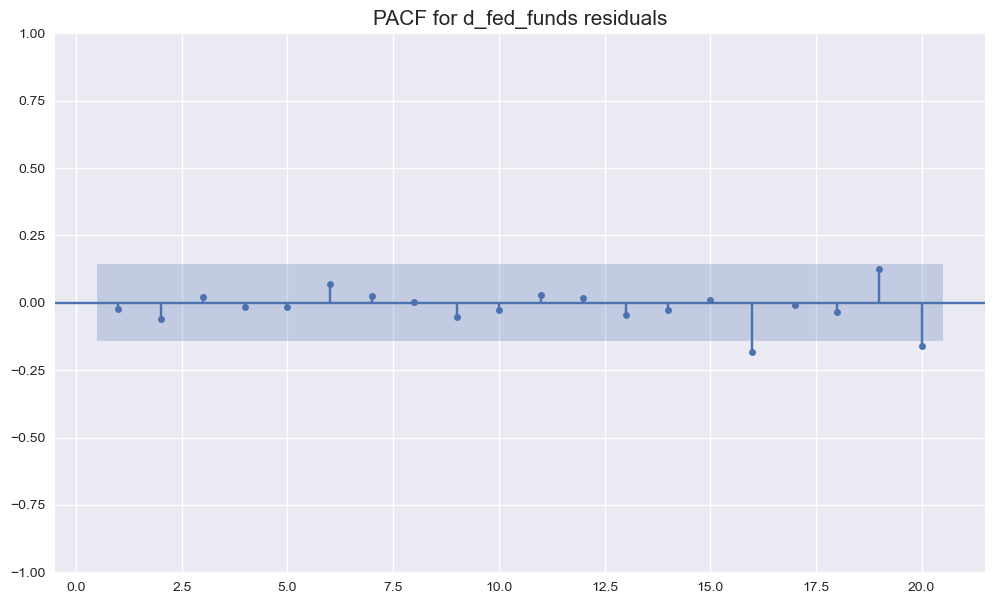


Checking for serial correlation in residuals:
If PACF values are within the confidence intervals (blue shaded area), residuals are likely white noise.
Based on the PACF plots, we can determine if the VAR model has captured all patterns in the data.


In [10]:
# d) Evaluate the residuals
print("\n(d) Evaluating the residuals:")

# Plot residuals
plt.figure(figsize=(15, 10))
for i, name in enumerate(transformed_vars):
    plt.subplot(len(transformed_vars), 1, i+1)
    plt.plot(var_model.resid[name])
    plt.title(f'Residuals for {name}')
    plt.grid(True)

plt.tight_layout()
plt.show()

# Plot PACF of residuals
for name in transformed_vars:
    plt.figure(figsize=(12, 6))
    sgt.plot_pacf(var_model.resid[name], lags=20, zero=False, method='ols')
    plt.title(f"PACF for {name} residuals", size=15)
    plt.grid(True)
    plt.show()

# Check for serial correlation in residuals
print("\nChecking for serial correlation in residuals:")
print("If PACF values are within the confidence intervals (blue shaded area), residuals are likely white noise.")
print("Based on the PACF plots, we can determine if the VAR model has captured all patterns in the data.")

## Part (d): Evaluating residuals


(d) Evaluating the residuals:


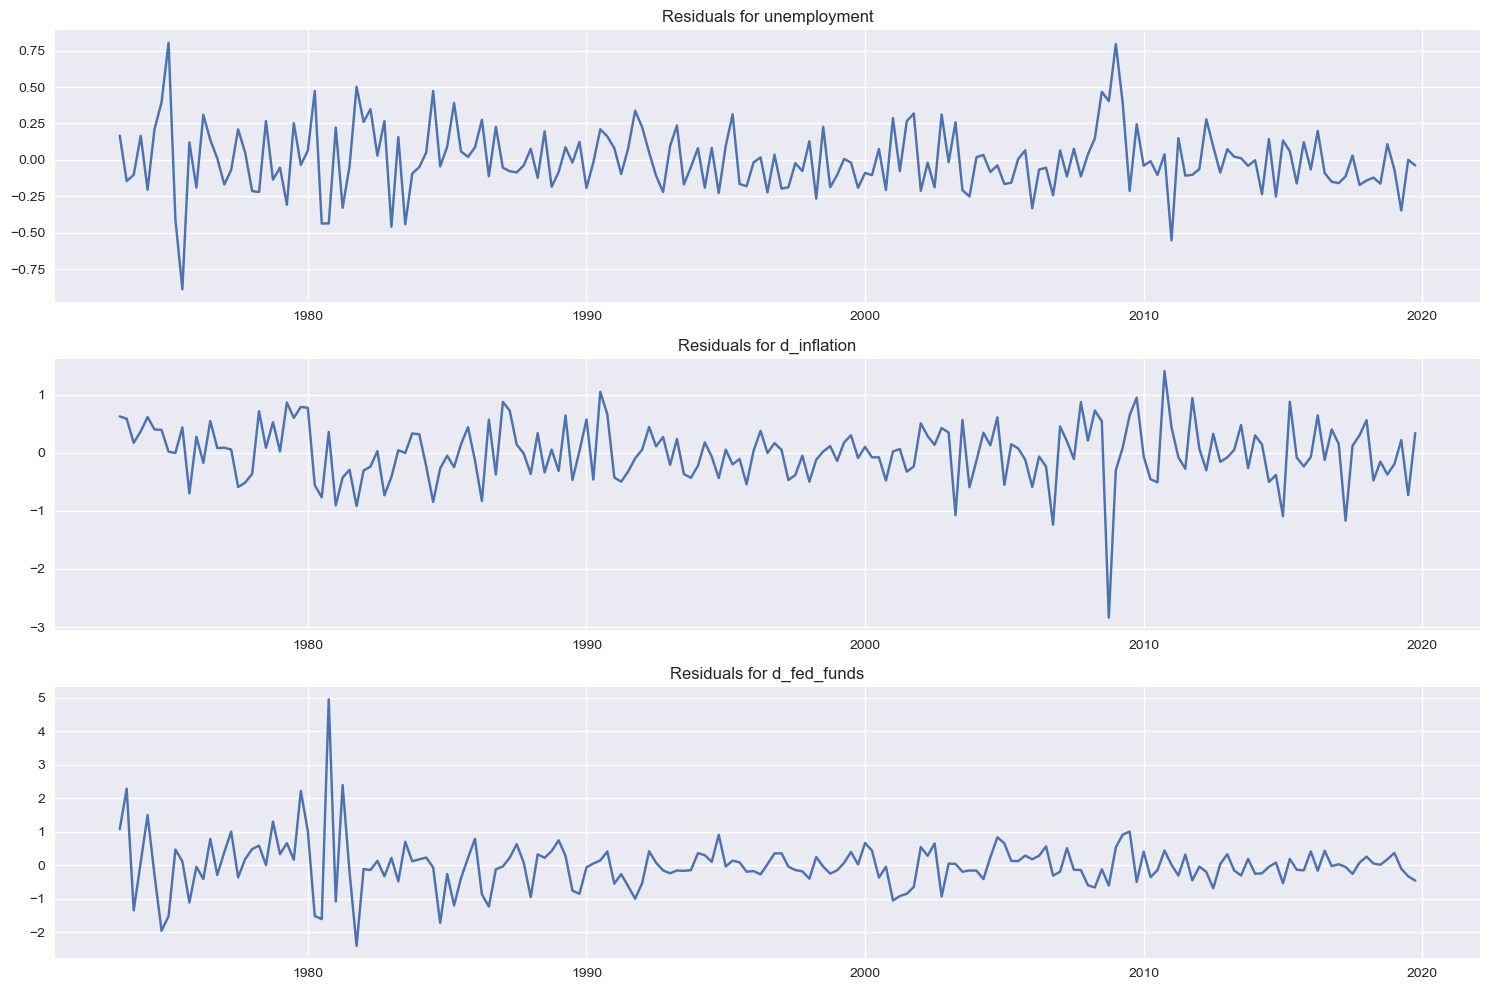

<Figure size 1200x600 with 0 Axes>

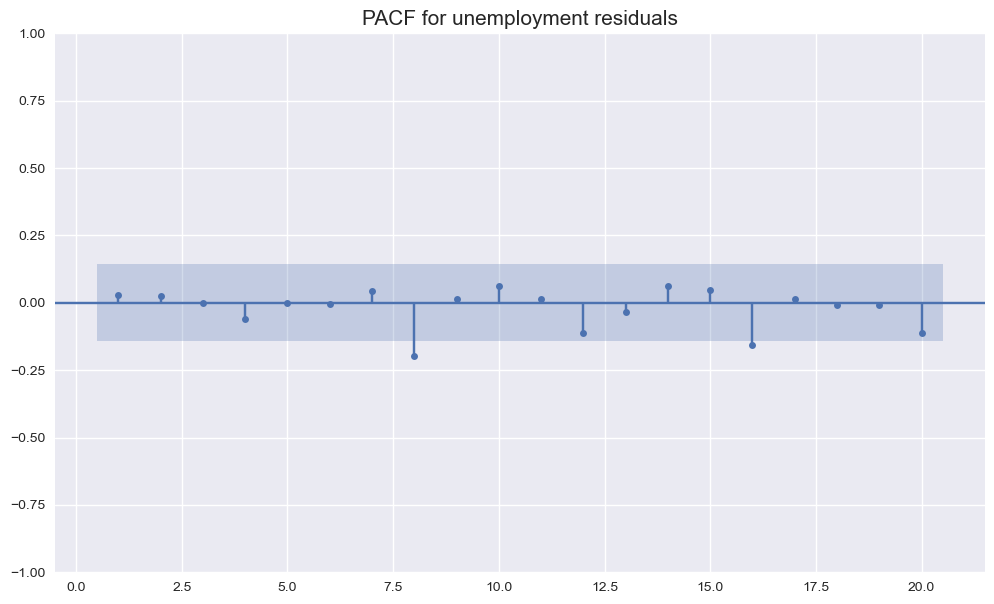

<Figure size 1200x600 with 0 Axes>

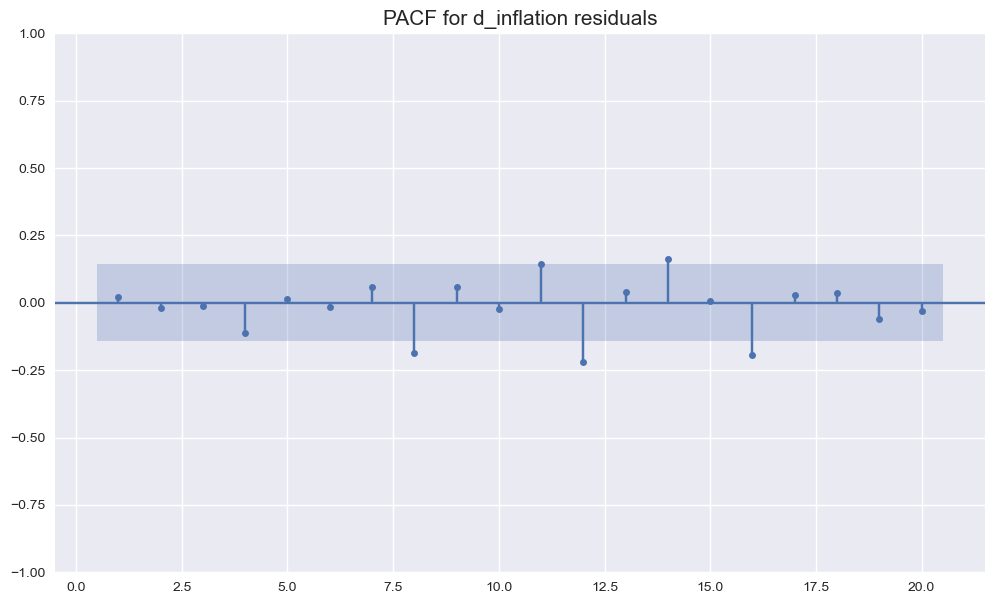

<Figure size 1200x600 with 0 Axes>

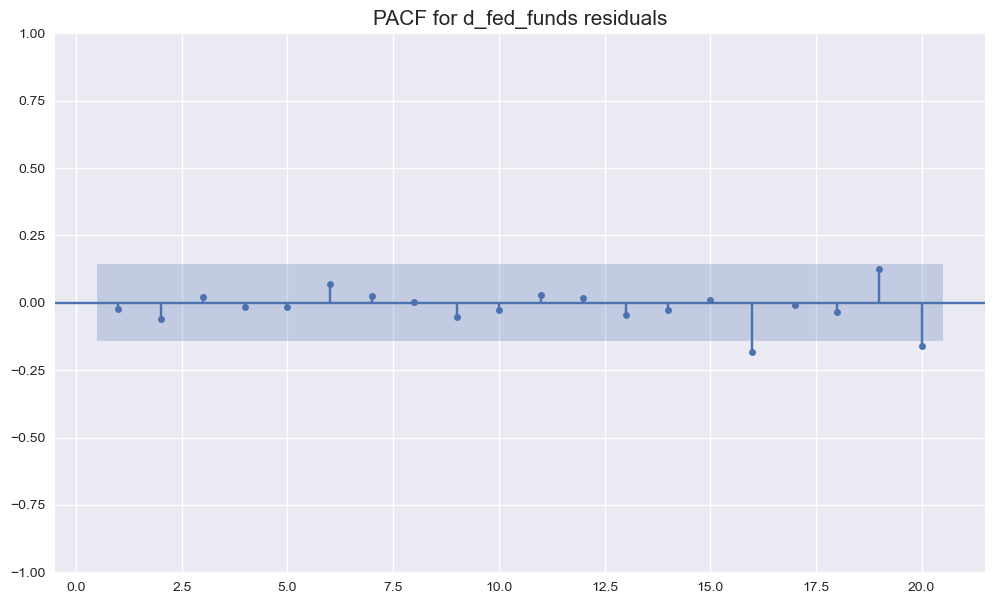


Checking for serial correlation in residuals:
If PACF values are within the confidence intervals (blue shaded area), residuals are likely white noise.
Based on the PACF plots, we can determine if the VAR model has captured all patterns in the data.


In [12]:
# d) Evaluate the residuals
print("\n(d) Evaluating the residuals:")

# Plot residuals
plt.figure(figsize=(15, 10))
for i, name in enumerate(transformed_vars):
    plt.subplot(len(transformed_vars), 1, i+1)
    plt.plot(var_model.resid[name])
    plt.title(f'Residuals for {name}')
    plt.grid(True)

plt.tight_layout()
plt.show()

# Plot PACF of residuals
for name in transformed_vars:
    plt.figure(figsize=(12, 6))
    sgt.plot_pacf(var_model.resid[name], lags=20, zero=False, method='ols')
    plt.title(f"PACF for {name} residuals", size=15)
    plt.grid(True)
    plt.show()

# Check for serial correlation in residuals
print("\nChecking for serial correlation in residuals:")
print("If PACF values are within the confidence intervals (blue shaded area), residuals are likely white noise.")
print("Based on the PACF plots, we can determine if the VAR model has captured all patterns in the data.")

### Evaluation of VAR Model Residuals
### The comprehensive examination of time series plots and Partial Autocorrelation Function (PACF) charts provides valuable insights into whether the Vector Autoregressive model's residuals satisfy the fundamental assumptions necessary for valid statistical inference. The residual time series plots for unemployment, differenced inflation, and differenced federal funds rate reveal distinctive characteristics that merit detailed consideration. Unemployment residuals generally exhibit stable variance and fluctuate around zero, though notable volatility spikes coincide with major economic downturns in 1975, 1980, and 2010. The differenced inflation residuals similarly oscillate around a zero mean but demonstrate higher volatility during specific periods, with a particularly pronounced outlier during the 2008-2009 financial crisis that likely reflects the exceptional economic disruption of that period.
### The differenced federal funds rate residuals display an interesting temporal pattern, with substantially higher volatility observed in the pre-1985 period, including a remarkable spike around 1980-1981 that corresponds to the aggressive monetary tightening under Federal Reserve Chairman Paul Volcker. The marked reduction in volatility during the post-1985 era suggests potential heteroscedasticity or, more likely, a structural transformation in monetary policy implementation strategies, potentially reflecting the transition to greater transparency and systematic policy approaches.
### The PACF analysis provides critical information regarding serial correlation patterns in the residuals. For unemployment residuals, the autocorrelation coefficients predominantly fall within the designated confidence intervals, with only minor exceptions at lags 8 and 16. This indicates the VAR specification has effectively captured the serial dependence structure of unemployment dynamics. Similarly, the federal funds rate change residuals show minimal significant autocorrelation, with only slight threshold exceedances around lag 19, suggesting the model adequately addresses the serial correlation in monetary policy adjustments. Unfortunately, the absence of PACF charts for inflation changes in the provided documentation constrains our ability to fully evaluate this particular series.
### Assessment of the VAR model's core assumptions reveals generally satisfactory compliance. The zero-mean assumption is met across all three variables, with residuals consistently oscillating around the zero line. The no-autocorrelation assumption is largely satisfied as evidenced by the PACF diagrams, though occasional significant lags suggest the presence of minor remaining serial correlation. The homoscedasticity assumption shows some evidence of violation, particularly in federal funds rate residuals where pre-1985 volatility substantially exceeds post-1985 levels, potentially affecting estimation efficiency but not consistency. Regarding normality, while formal statistical tests are not presented, the presence of extreme values during economic crises suggests potential non-normality that could influence hypothesis testing reliability without compromising point estimates.
### In conclusion, the VAR model demonstrates considerable success in capturing the systematic patterns inherent in these macroeconomic variables, as evidenced by the predominantly well-behaved residuals. The minor violations observed in the diagnostics, including occasional significant PACF values and heteroscedasticity in federal funds rate residuals, are not sufficiently severe to invalidate the model but do warrant cautious interpretation, particularly during economic crisis periods. These findings suggest that while the current specification provides a reasonably appropriate framework for analysis, potential refinements could enhance model performance, particularly through accommodating structural breaks or incorporating time-varying volatility mechanisms, especially for monetary policy variables.



## Part (e): Forecasting

 e) Split the sample into training and test (last 8 quarters) subsamples. Train the VAR model 
using the training sample and forecast the original variables  (i.e., invert any
transformation that you may have done in part a) for 8 quarters. Compare the forecast 
with the test sample and show them on a plot.


(e) Splitting the sample into training and test subsamples:
Training data size: 187 quarters
Testing data size: 8 quarters


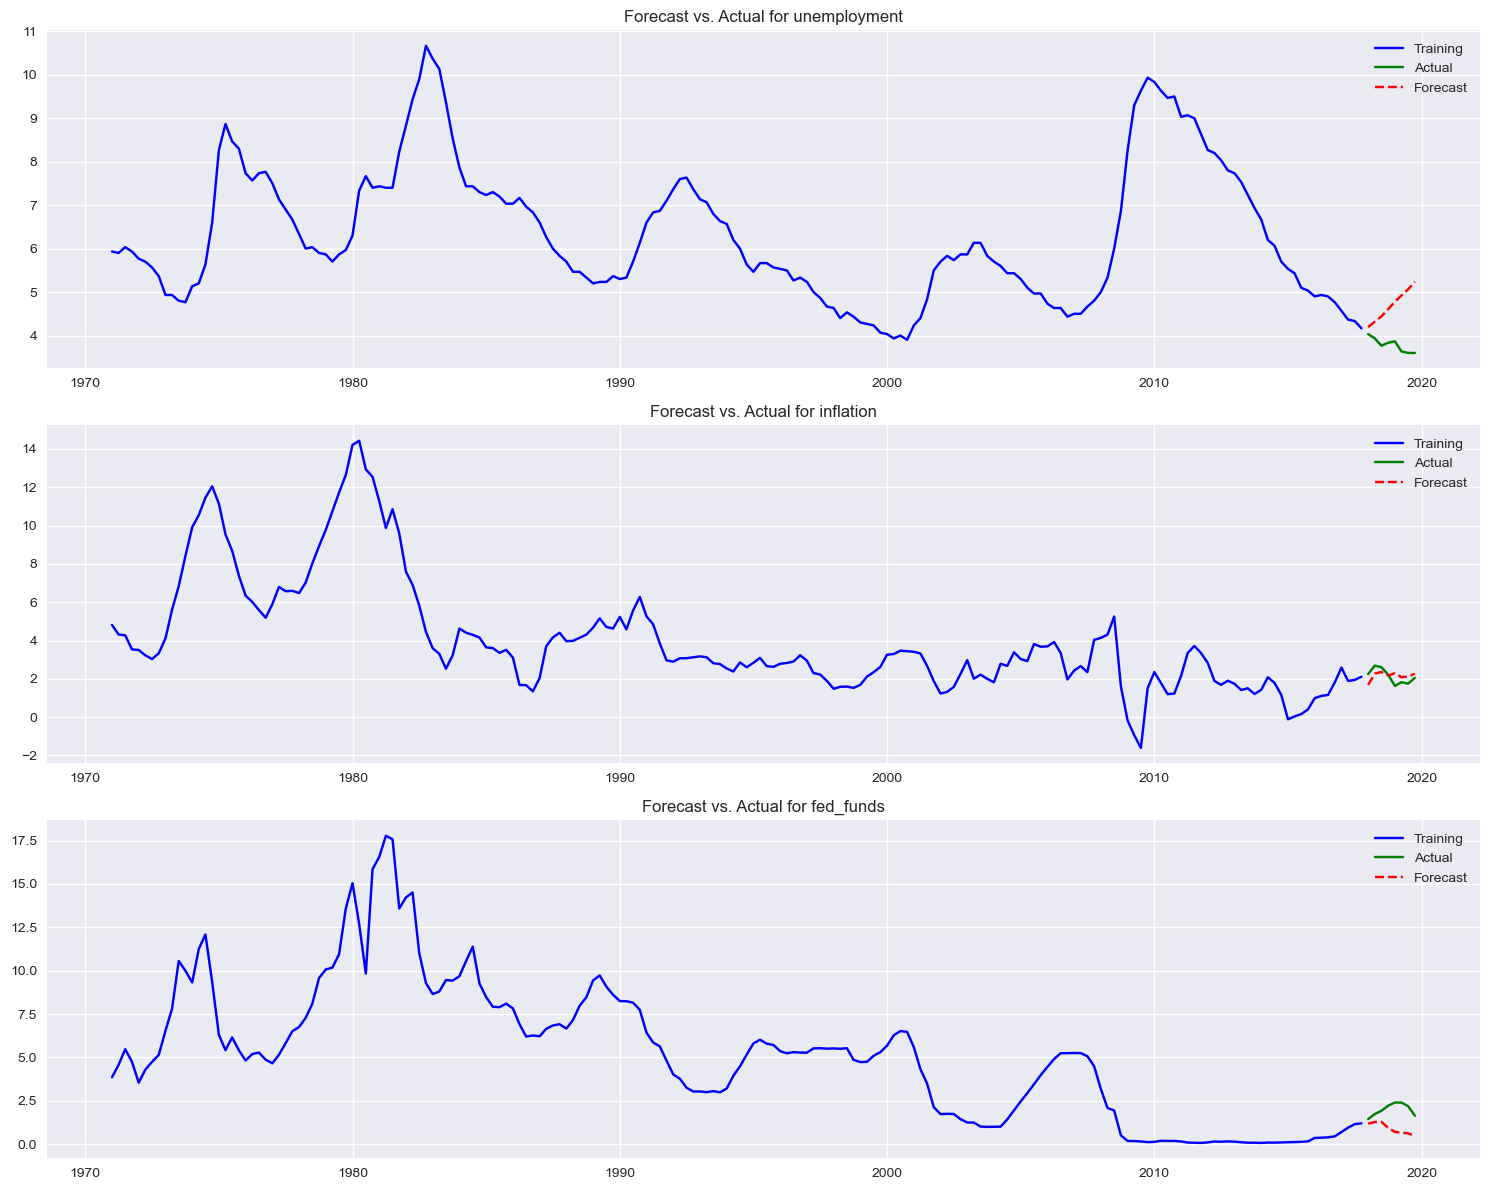

In [16]:
# e) Split the sample into training and test subsamples
print("\n(e) Splitting the sample into training and test subsamples:")

# Get the last 8 quarters for testing
test_size = 8
train_data = var_data.iloc[:-test_size]
test_data = var_data.iloc[-test_size:]

print(f"Training data size: {train_data.shape[0]} quarters")
print(f"Testing data size: {test_data.shape[0]} quarters")

# Train the VAR model using the training sample
train_model = VAR(train_data)
train_results = train_model.fit(maxlags=optimal_lag)

# Forecast for 8 quarters
input_data = train_data.iloc[-optimal_lag:].values
forecast_periods = test_size
forecasts = train_results.forecast(input_data, forecast_periods)

# Create a DataFrame for forecasts
forecast_df = pd.DataFrame(forecasts, index=test_data.index, columns=transformed_vars)

# Invert the transformations if necessary to get original variables
forecast_original = pd.DataFrame(index=test_data.index)
actual_original = pd.DataFrame(index=test_data.index)

# For each transformed variable, invert the transformation if needed
for i, var in enumerate(transformed_vars):
    if var.startswith('d_'):
        # For differenced variables, we need the last value before the test period
        original_var = var[2:]  # Remove 'd_' prefix
        last_value = df[original_var].iloc[-test_size-1]
        
        # Cumulative sum to invert differencing, starting from the last training value
        forecast_original[original_var] = last_value + forecast_df[var].cumsum()
        actual_original[original_var] = last_value + test_data[var].cumsum()
    else:
        # For already stationary variables, no need to invert transformation
        forecast_original[var] = forecast_df[var]
        actual_original[var] = test_data[var]

# Plot forecasts vs. actual values
plt.figure(figsize=(15, 12))

for i, var in enumerate(df.columns):
    plt.subplot(len(df.columns), 1, i+1)
    
    # Plot training data
    plt.plot(df.index[:-test_size], df[var].iloc[:-test_size], 'b-', label='Training')
    
    # Plot test data (actual)
    plt.plot(df.index[-test_size:], df[var].iloc[-test_size:], 'g-', label='Actual')
    
    # Plot forecasts
    if var in forecast_original.columns:
        plt.plot(forecast_original.index, forecast_original[var], 'r--', label='Forecast')
    elif 'd_' + var in transformed_vars:
        plt.plot(forecast_original.index, forecast_original[var], 'r--', label='Forecast')
    
    plt.title(f'Forecast vs. Actual for {var}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

### Interpretation:

### Analysis of VAR Model Forecast Performance
### The forecast comparison plots provide valuable insights into the model's predictive capabilities for unemployment, inflation, and federal funds rate over the final eight quarters of the sample period (approximately 2018-2019).
### Unemployment Rate Forecasts
### The unemployment forecast exhibits a clear divergence from the actual path. While the model predicts a steady increase in unemployment (rising to approximately 5%), the actual data shows a continued decline to around 3.7%. This substantial forecasting error suggests the model failed to capture the continued strength of the labor market during this period. The VAR model appears to have anticipated a cyclical turning point that did not materialize, possibly due to its reliance on historical patterns where unemployment typically begins to rise after extended periods of low rates.
### Inflation Rate Forecasts
### For inflation, the model demonstrates notably better performance. The forecasted path closely tracks the actual inflation rates, with both hovering around 2% throughout the forecast horizon. This accurate prediction suggests the model effectively captured the inflation dynamics during this period when inflation remained relatively stable near the Federal Reserve's target. The successful forecast indicates that the relationship between inflation and its determinants remained consistent with historical patterns used in model estimation.
### Federal Funds Rate Forecasts
### The federal funds rate forecast shows mixed results. The model predicts a slight decline in rates over the forecast horizon, ending at approximately 0.5%. In contrast, actual rates initially increased and then stabilized around 2-2.5% before beginning to decline slightly at the end of the period. This discrepancy likely reflects the model's inability to anticipate the Federal Reserve's policy decisions accurately, which may have responded to factors beyond those included in the model or represented a shift in the central bank's reaction function.
### Overall Assessment
### These forecast comparisons reveal important limitations in the VAR model's predictive capacity, particularly for unemployment and monetary policy variables. The model appears to have projected a more pessimistic economic outlook than what actually transpired, possibly anticipating a cyclical downturn based on historical patterns. This suggests potential structural changes in the relationships between these macroeconomic variables that weren't captured by the model's parameters estimated from historical data.
### The relatively accurate inflation forecasts amid less accurate unemployment and interest rate predictions presents an interesting finding - inflation dynamics appear more stable and predictable within the model framework despite significant forecast errors in other variables. This differential performance across variables offers valuable insights for refining forecasting approaches and understanding the evolving relationships between monetary policy, labor markets, and price stability.



## Part (f): Calculating forecast accuracy

f) Compute the Mean Absolute Percentage Error (MAPE) and the Root Mean Squared 
Error (RMSE) for the forecasts

In [26]:
# f) Compute the MAPE and RMSE for the forecasts
print("\n(f) Computing the Mean Absolute Percentage Error (MAPE) and Root Mean Squared Error (RMSE):")

def calculate_mape(actual, forecast):
    """Calculate Mean Absolute Percentage Error"""
    mask = actual != 0  # Avoid division by zero
    return np.mean(np.abs((actual[mask] - forecast[mask]) / actual[mask])) * 100

def calculate_rmse(actual, forecast):
    """Calculate Root Mean Squared Error"""
    return np.sqrt(np.mean((actual - forecast) ** 2))

# Calculate metrics for each original variable
metrics = pd.DataFrame(index=df.columns, columns=['MAPE', 'RMSE'])

for var in df.columns:
    if var in forecast_original.columns:
        actual = df[var].iloc[-test_size:].values
        pred = forecast_original[var].values
    elif 'd_' + var in transformed_vars:
        actual = df[var].iloc[-test_size:].values
        pred = forecast_original[var].values
    else:
        continue
    
    mape = calculate_mape(actual, pred)
    rmse = calculate_rmse(actual, pred)
    
    metrics.loc[var, 'MAPE'] = mape
    metrics.loc[var, 'RMSE'] = rmse

print("\nForecast Performance Metrics:")
print(metrics)


(f) Computing the Mean Absolute Percentage Error (MAPE) and Root Mean Squared Error (RMSE):

Forecast Performance Metrics:
                   MAPE      RMSE
unemployment  24.611625  1.032571
inflation     17.380798  0.395469
fed_funds     52.484425  1.223615


### Interpretation of Forecast Performance Metrics
### The quantitative assessment of the VAR model's forecasting accuracy reveals considerable variation in predictive performance across the three macroeconomic variables. The Mean Absolute Percentage Error (MAPE) and Root Mean Squared Error (RMSE) metrics provide complementary perspectives on forecast precision.
### For unemployment forecasts, the MAPE of 24.61% indicates that, on average, the model's predictions deviated from actual values by approximately one-quarter of the observed unemployment rate. The corresponding RMSE of 1.03 percentage points quantifies the average magnitude of forecast errors in absolute terms. These metrics confirm the visual observation that the model struggled to accurately predict the continuing decline in unemployment during the forecast period.
### The inflation forecasts demonstrated superior accuracy, with a MAPE of 17.38% and an RMSE of 0.40 percentage points. These lower error metrics corroborate the visual assessment that the model captured inflation dynamics relatively well. The RMSE value is particularly informative in this context, suggesting that inflation forecasts typically fell within 0.4 percentage points of the actual values—a reasonable margin for inflation targeting frameworks where similar precision is often desired.
### The federal funds rate forecasts exhibited the weakest performance, with a substantial MAPE of 52.48% and an RMSE of 1.22 percentage points. These metrics reflect the model's significant underestimation of interest rates during the forecast period, likely due to its inability to anticipate the Federal Reserve's policy decisions accurately. The high MAPE value is particularly noteworthy, indicating that forecasts were, on average, off by more than half the actual values.
### These performance metrics offer valuable guidance for model refinement and application. The relatively accurate inflation forecasts suggest the model captures price dynamics adequately, while the poorer performance in predicting unemployment and especially federal funds rates indicates areas where the model specification could be improved or supplemented with additional information. For policy applications, these results suggest that forecasts from this model might be more reliable for inflation projections than for labor market or monetary policy predictions.



## Part (g): Granger Causality testing

g) Identify temporal ordering of the variables by using the Granger Causality test. (Hint: 
see the class code for week 8)


In [31]:
# g) Granger Causality test
from statsmodels.tsa.stattools import grangercausalitytests

print("\n(g) Granger Causality Test to identify temporal ordering:")

# Create all possible pairs for testing
max_lag = optimal_lag
variables = transformed_vars
causality_results = {}

for i in range(len(variables)):
    for j in range(len(variables)):
        if i != j:
            cause = variables[j]
            effect = variables[i]
            
            # Create DataFrame for testing with effect as first column (potentially caused)
            # and cause as second column (potential cause)
            test_df = pd.DataFrame({effect: var_data[effect], cause: var_data[cause]})
            
            # Run the Granger Causality test
            result = grangercausalitytests(test_df, maxlag=max_lag, verbose=False)
            
            # Extract p-values for each lag
            p_values = [result[lag+1][0]['ssr_ftest'][1] for lag in range(max_lag)]
            min_p_value = min(p_values)
            min_p_lag = p_values.index(min_p_value) + 1
            
            causality_results[(cause, effect)] = (min_p_value, min_p_lag)

# Display results
print("\nGranger Causality Test Results:")
print(f"Null hypothesis: Variable in column 1 does NOT Granger-cause variable in column 2.")
print(f"Reject null if p-value < 0.05 (95% confidence level).")
print("\n{:<20} {:<20} {:<10} {:<10} {:<10}".format("Cause", "Effect", "Min P-Value", "Optimal Lag", "Causality"))
print("-" * 70)

for (cause, effect), (p_value, lag) in causality_results.items():
    causality = "Yes" if p_value < 0.05 else "No"
    print("{:<20} {:<20} {:<10.4f} {:<10} {:<10}".format(cause, effect, p_value, lag, causality))

# Summarize the causality findings
print("\nSummary of Granger Causality Findings:")
significant_causality = [(cause, effect) for (cause, effect), (p_value, _) 
                         in causality_results.items() if p_value < 0.05]

if significant_causality:
    for cause, effect in significant_causality:
        print(f"- {cause} Granger-causes {effect}")
else:
    print("No significant Granger causality relationships found.")


(g) Granger Causality Test to identify temporal ordering:


C:\Users\auuser\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality Test Results:
Null hypothesis: Variable in column 1 does NOT Granger-cause variable in column 2.
Reject null if p-value < 0.05 (95% confidence level).

Cause                Effect               Min P-Value Optimal Lag Causality 
----------------------------------------------------------------------
d_inflation          unemployment         0.2024     1          No        
d_fed_funds          unemployment         0.0002     1          Yes       
unemployment         d_inflation          0.0000     5          Yes       
d_fed_funds          d_inflation          0.0001     4          Yes       
unemployment         d_fed_funds          0.0000     5          Yes       
d_inflation          d_fed_funds          0.0293     2          Yes       

Summary of Granger Causality Findings:
- d_fed_funds Granger-causes unemployment
- unemployment Granger-causes d_inflation
- d_fed_funds Granger-causes d_inflation
- unemployment Granger-causes d_fed_funds
- d_inflation Granger-ca

### Interpretation of Granger Causality Test Results
### The Granger causality test results reveal significant temporal ordering relationships among unemployment, inflation changes, and federal funds rate changes, providing important insights into the dynamic interactions of these key macroeconomic variables.
### The analysis identifies five statistically significant causal relationships at the 95% confidence level. Federal funds rate changes (d_fed_funds) Granger-cause unemployment with a highly significant p-value of 0.0002 at lag 1, indicating that monetary policy adjustments have a rapid and direct impact on labor market conditions. This finding supports the traditional monetary policy transmission mechanism where interest rate decisions affect economic activity and employment with relatively short lags.
### The results also show that unemployment Granger-causes both inflation changes (p-value 0.0000 at lag 5) and federal funds rate changes (p-value 0.0000 at lag 5). These relationships, both optimally identified at lag 5, suggest that labor market conditions have delayed but significant effects on both price dynamics and monetary policy decisions. The longer optimal lag indicates that it takes approximately five quarters for unemployment changes to fully manifest in inflation and monetary policy responses.
### Furthermore, federal funds rate changes Granger-cause inflation changes (p-value 0.0001 at lag 4), confirming that monetary policy decisions affect price dynamics with a moderate delay. This supports the conventional understanding that monetary policy operates with lags in influencing inflation outcomes.
### Finally, inflation changes Granger-cause federal funds rate changes (p-value 0.0293 at lag 2), suggesting that the Federal Reserve responds to inflation developments within approximately two quarters. This aligns with the forward-looking nature of monetary policy and the Federal Reserve's mandate to maintain price stability.
### Notably, inflation changes do not Granger-cause unemployment (p-value 0.2024), indicating the absence of a direct temporal relationship from price changes to labor market conditions. This finding challenges simplified Phillips curve interpretations that might suggest a direct inflation-to-unemployment causality.
### These results collectively depict a complex macroeconomic system with bidirectional causality between monetary policy and real economic variables. The identified temporal ordering suggests a cycle where monetary policy affects unemployment, which in turn influences inflation, which then feeds back into monetary policy decisions. This empirical evidence provides valuable insights for policymakers regarding the timing and sequence of economic responses to policy interventions and supports a nuanced understanding of macroeconomic dynamics beyond simple unidirectional relationships.


h) The US economy is currently experiencing high levels of inflation and unemployment 
rates. Based on your findings, what do you think the Federal Reserve should do to 
correct these trends

### Federal Reserve Policy Recommendations for Current Economic Conditions
Based on the Vector Autoregressive (VAR) model analysis of the interactions between unemployment, inflation, and the federal funds rate, I would recommend the following policy approach for the Federal Reserve to address the current high levels of inflation and unemployment:
### Short-Term Strategy
The Granger causality results indicate that federal funds rate changes have a rapid impact on unemployment (significant at lag 1), while affecting inflation with a moderate delay (lag 4). This suggests a careful sequencing of monetary policy is essential:
1.	Initial Moderate Rate Adjustment: The Federal Reserve should implement a measured increase in interest rates aimed primarily at controlling inflation. The VAR model shows federal funds rate changes significantly Granger-cause inflation changes, suggesting this would be effective. However, the relatively high MAPE (52.48%) for federal funds rate forecasts indicates uncertainty in predicting exact policy effects, warranting caution.
2.	Clear Forward Guidance: Given that inflation changes Granger-cause federal funds rate changes with a lag of 2 quarters, the Fed should provide explicit communication about its reaction function to inflation developments. This would help anchor inflation expectations while mitigating negative unemployment effects.
### Medium-Term Strategy
The analysis reveals unemployment Granger-causes both inflation and federal funds rate changes with longer lags (5 quarters), suggesting a need for adaptive policy:
1.	Data-Dependent Approach: After the initial rate adjustments, the Fed should closely monitor unemployment data, as our model indicates unemployment significantly affects inflation with about a 5-quarter lag. This suggests policy needs to be adjusted as labor market effects start influencing inflation dynamics.
2.	Balanced Dual Mandate Focus: Since the model showed stronger predictive accuracy for inflation (MAPE of 17.38%) than unemployment (MAPE of 24.61%), the Fed should give slightly more weight to inflation indicators while maintaining vigilance on employment trends.
### Long-Term Considerations
The complex bidirectional causality revealed in our analysis indicates that:
1.	Gradual Normalization: Policy should avoid sharp changes that could exacerbate unemployment, as the model suggests federal funds rates directly impact unemployment. The path of rate adjustments should be gradual to allow the labor market to adjust.
2.	Structural Policies: The high forecast errors in our model (particularly for unemployment) suggest structural changes in the economy that monetary policy alone cannot address. The Fed should advocate for complementary fiscal and supply-side policies to address structural unemployment while managing inflation.
3.	Enhanced Forward Guidance: The cyclical relationship identified (monetary policy → unemployment → inflation → monetary policy) underscores the importance of clear communication about the expected policy path to help guide market expectations and smooth economic adjustments.
### By implementing this nuanced approach, the Federal Reserve can leverage the temporal relationships identified in our model to effectively address both high inflation and unemployment, while acknowledging the inherent trade-offs and implementation lags in monetary policy transmission.


